In [1]:
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.image as mpimg
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')

### Способ подобрать изображение - стиль для конкретного контента

Можно кластеризовать пиксели изображения-контента, тогда, получив сегментированное избражение, мы сможем оценить количество сегментов, занимаемую ими площадь и другие признаки, по которым можно каждому изображению-контенту можно поставить в соответствие подходящее изображение-стиль

In [2]:
# функция для разделения сегментов изображения и получения статистики по ним
def reshape_N_5_denisions(arr):
    assert len(arr.shape) == 3, \
        "we need 3 dimension matrix"

    width = arr.shape[0]
    height = arr.shape[1]
    arr = np.reshape(arr, [-1, 3])
    ind = np.indices((width, height))

    dem = np.stack((np.reshape(ind[0], -1), np.reshape(ind[1], -1))).T
    arr = np.concatenate((dem, arr), axis=1)
    return arr


def get_image_segments(image_path):
    image = Image.open(image_path)

    # Image is (687 x 1025, RGB channels)
    image = np.array(image)
    original_shape = image.shape

    # Flatten image.
    X = np.reshape(image, [-1, 3])
#     X = reshape_N_5_denisions(image)

    # гиперпараметр  
    bandwidth = 20
    
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X)
    
    
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    labels_unique = np.unique(labels)

    features = np.empty(4, dtype=int)
    features[0] = len(labels_unique)
    print("number of clusters : %d" % features[0])
    _clusters_ = np.zeros(len(labels_unique)+1, dtype=int)

    for i in labels:
        _clusters_[i]+=1
    
    features[1] = np.amax(_clusters_)
    print("max area : %d" % features[1])
    features[2] = np.median(_clusters_)
    print("median area : %d" % features[2])
    features[3] = np.sum(sorted(_clusters_)[:len(_clusters_) // 5])
    print("area of 20 percent's smallest segments : %d" % features[3])
    
    

#     for i, n in enumerate(sorted(_clusters_, reverse=True)[:min(10,_clusters_.shape[0])]):
#         print("cluster {}: area {}".format(i, n))
    
    

    # отбрасываем RGB
    segmented_image = np.reshape(labels, original_shape[:2])    
    plt.figure(figsize=(50,100))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image)
    plt.axis('off')
    return features


Получим признаки для изображений, которые мы ранее стилизовали

number of clusters : 9
max area : 72583
median area : 23237
area of 20 percent's smallest segments : 94


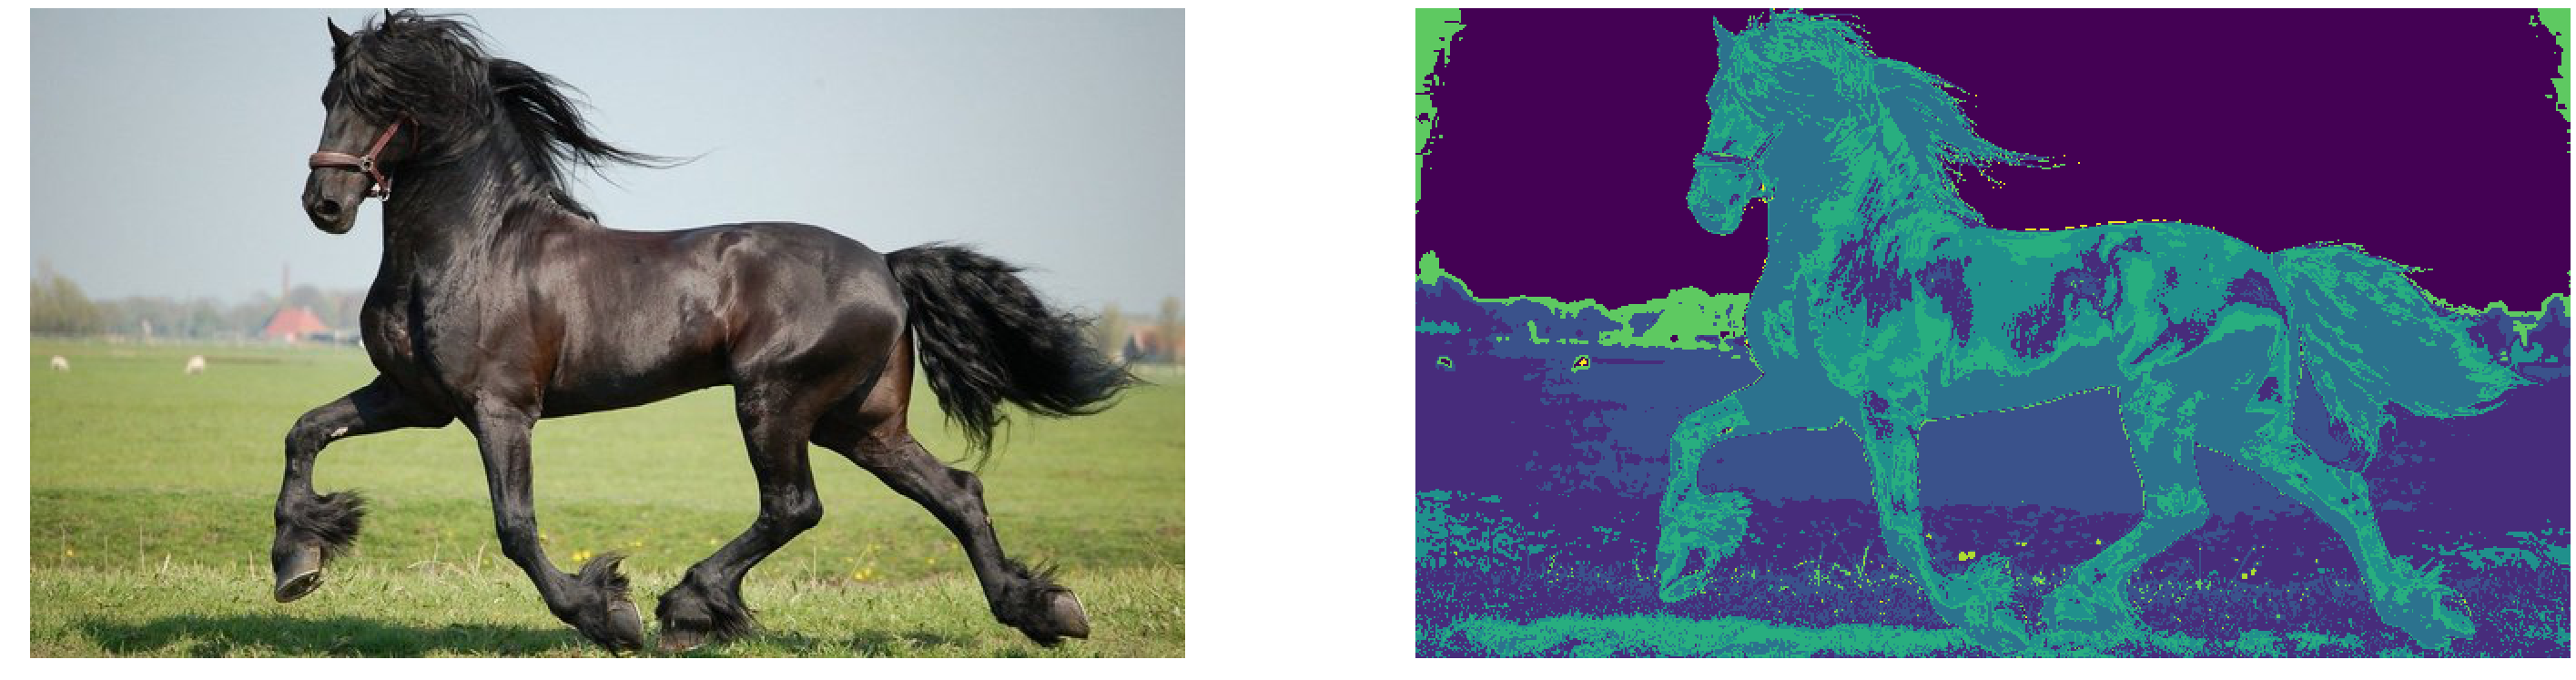

In [4]:
f = get_image_segments( "images/horse_640x360.jpg") # best (in my opinion) 1
features = np.array([f])

number of clusters : 37
max area : 51566
median area : 131
area of 20 percent's smallest segments : 14


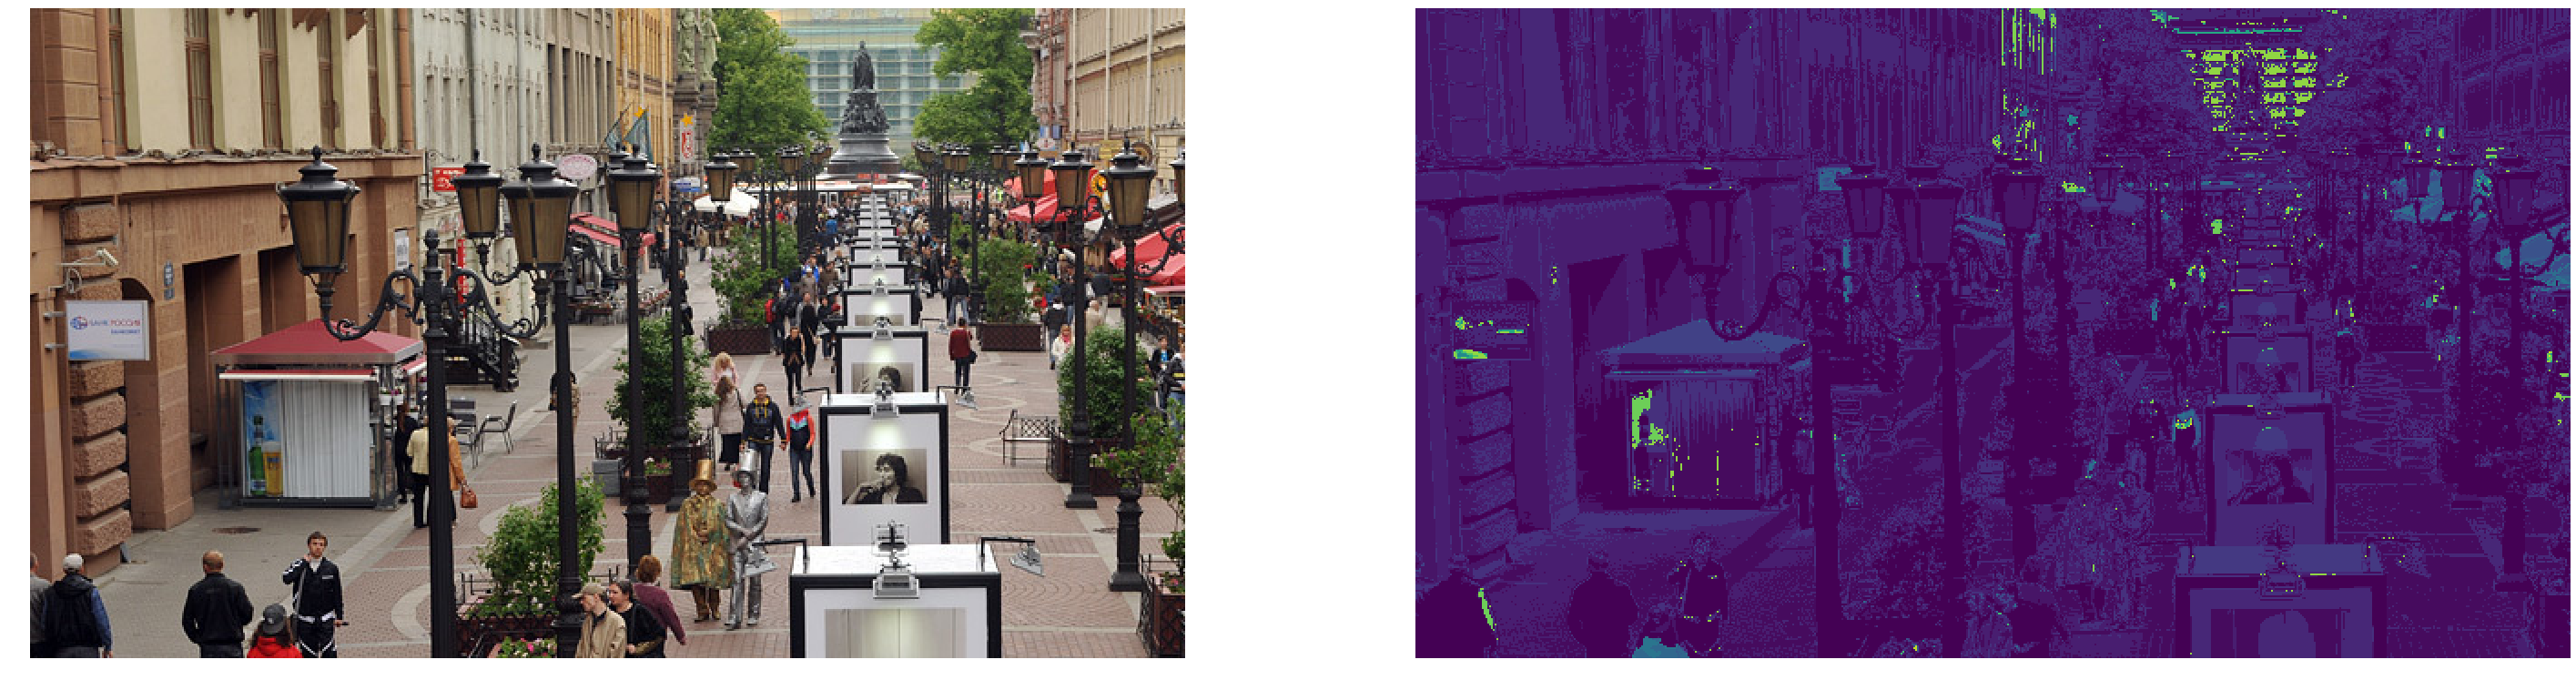

In [6]:
f = get_image_segments("images/town_640x360.jpg") # best (in my opinion) 4
features = np.vstack([features, f])

Хорошо видно, что у изображения города по сравнению с изображением коня:  
* число сегментов намного больше,  
* площадь самого крупного сегмента меньше,  
* медианная площадь меньше
* площать 20% самых маленьких сегментов меньше

Следственно, предложенный алгоритм действительно может быть использован для классификации изображений и последующей стилизации каждого класса своей текстурой.

Продолжим выделять фичи на разных изображениях:

number of clusters : 41
max area : 37252
median area : 1028
area of 20 percent's smallest segments : 326


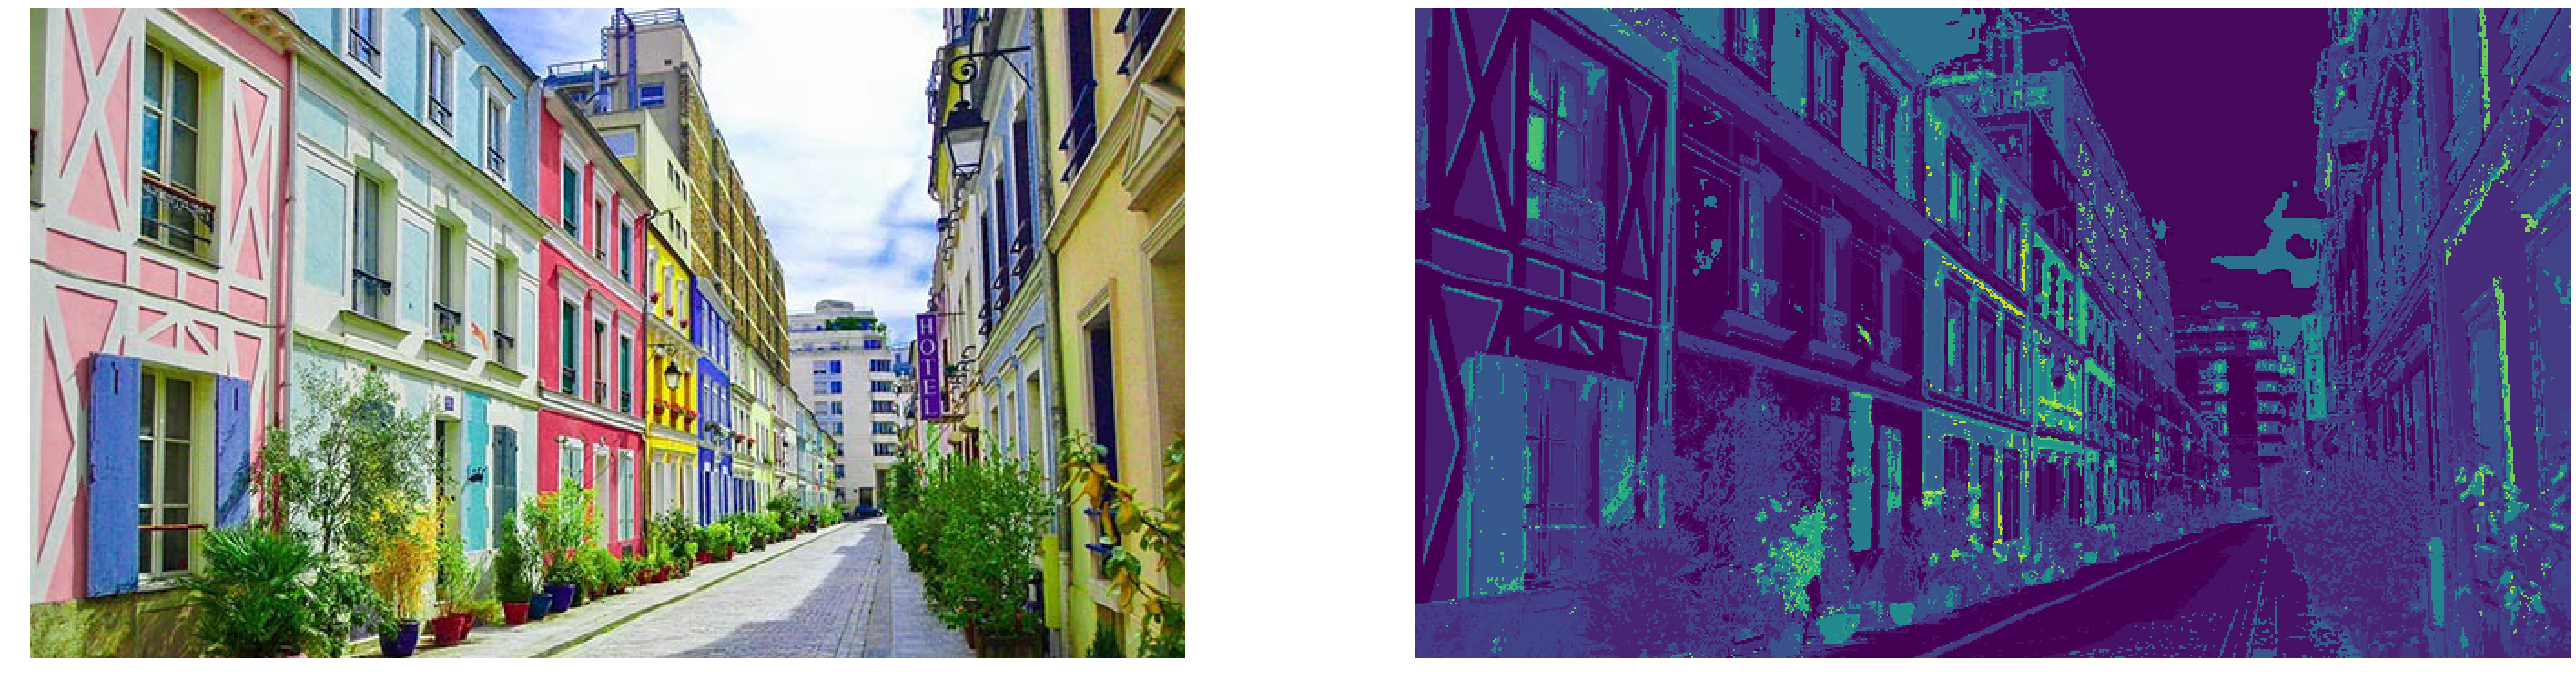

In [8]:
f = get_image_segments("images/t_640x360.jpg") # best (in my opinion) 3
features = np.vstack([features, f])

number of clusters : 23
max area : 90774
median area : 17
area of 20 percent's smallest segments : 6


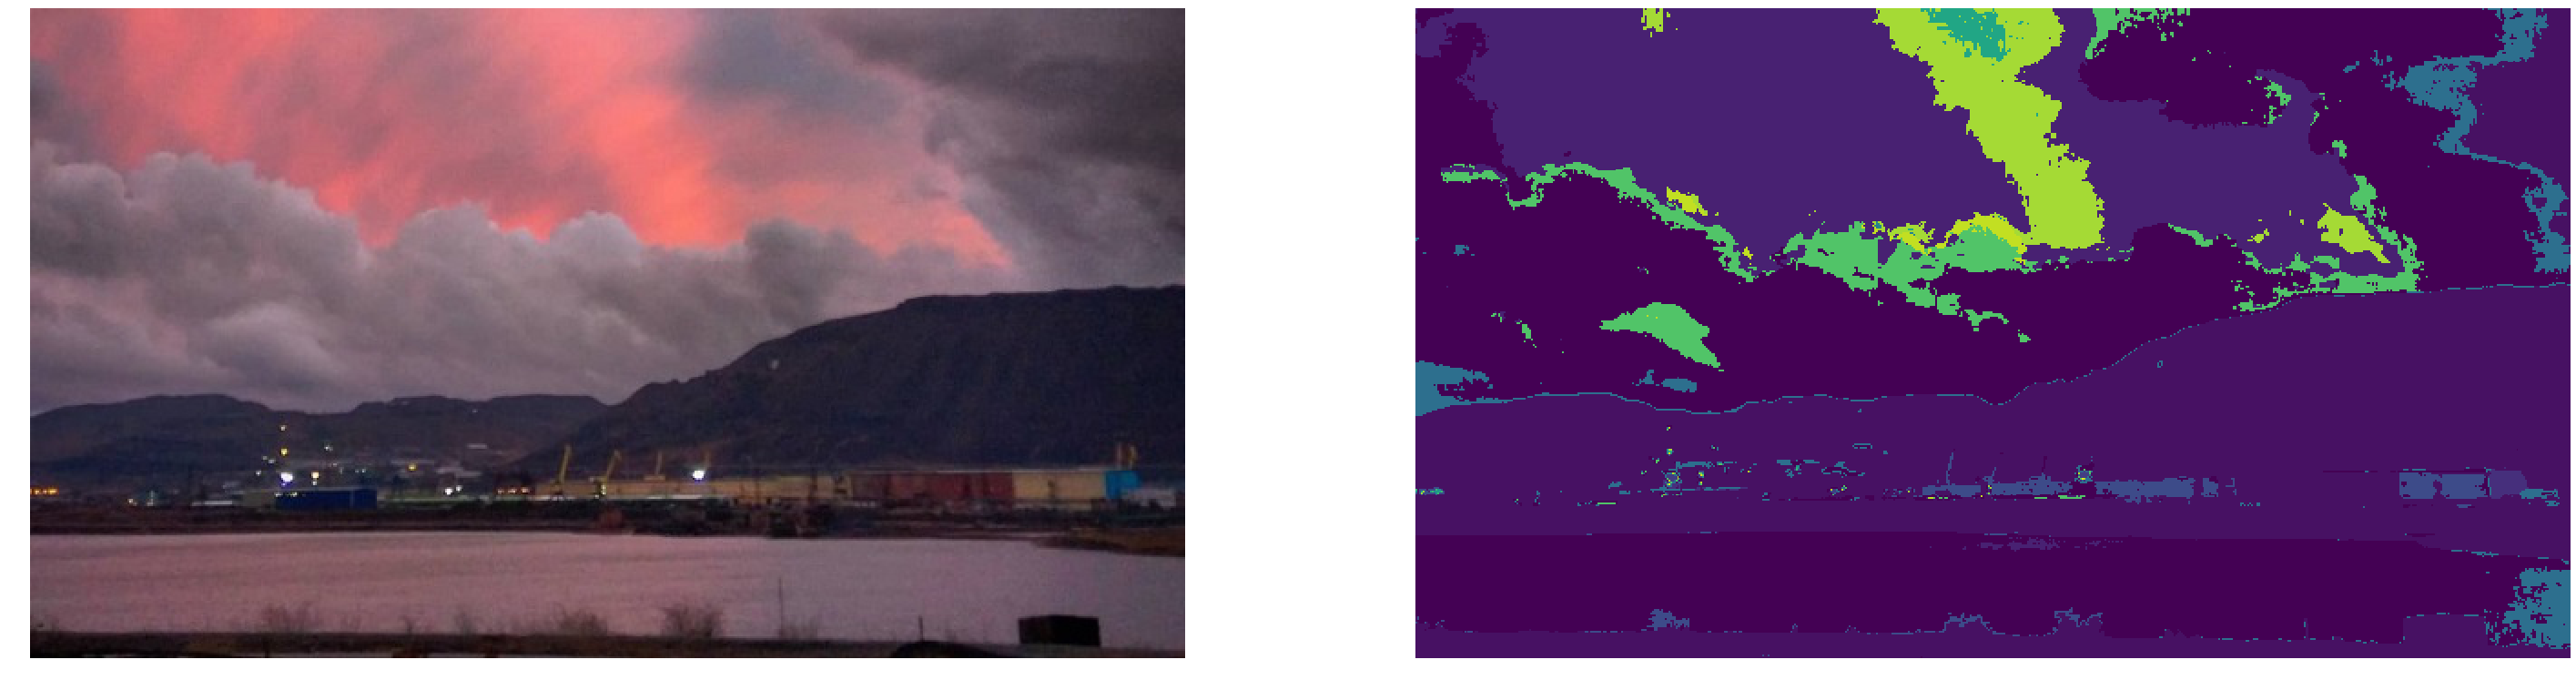

In [10]:
f = get_image_segments("images/pink_sky_640x360.jpg") # best (in my opinion) 1
features = np.vstack([features, f])

number of clusters : 15
max area : 68213
median area : 9362
area of 20 percent's smallest segments : 64


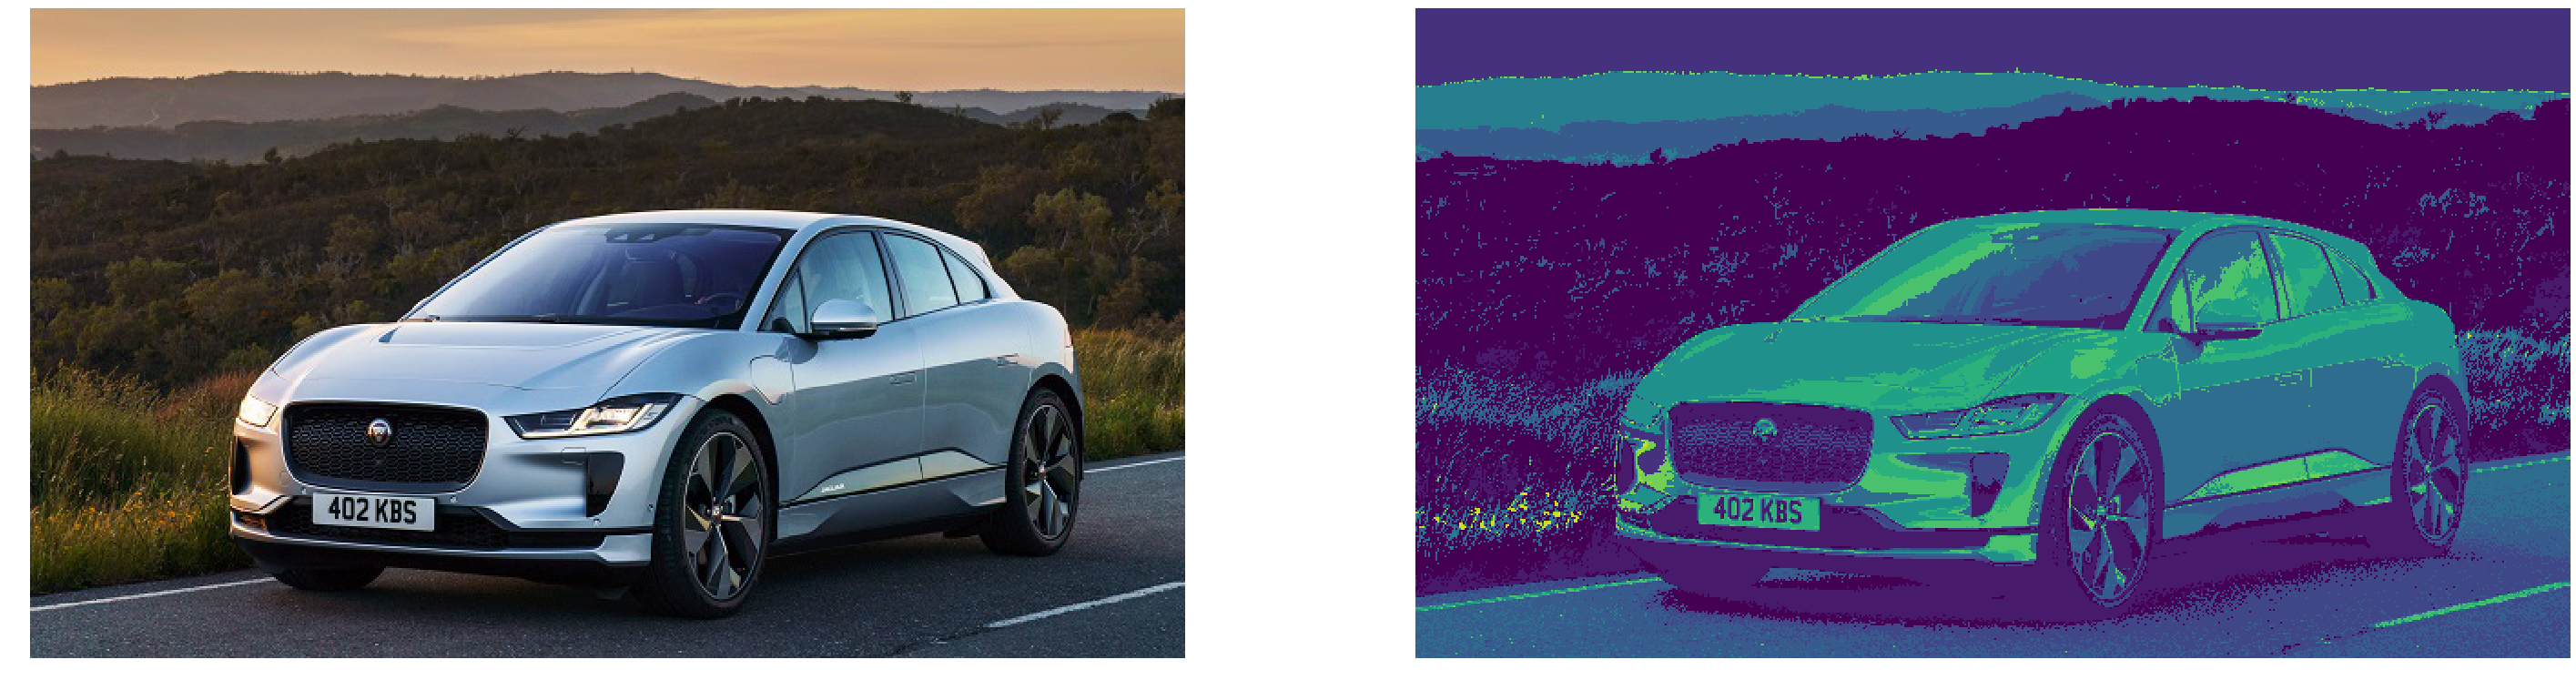

In [12]:
f = get_image_segments("images/car_640x360.jpg") # best (in my opinion) 2
features = np.vstack([features, f])

number of clusters : 5
max area : 122954
median area : 16956
area of 20 percent's smallest segments : 0


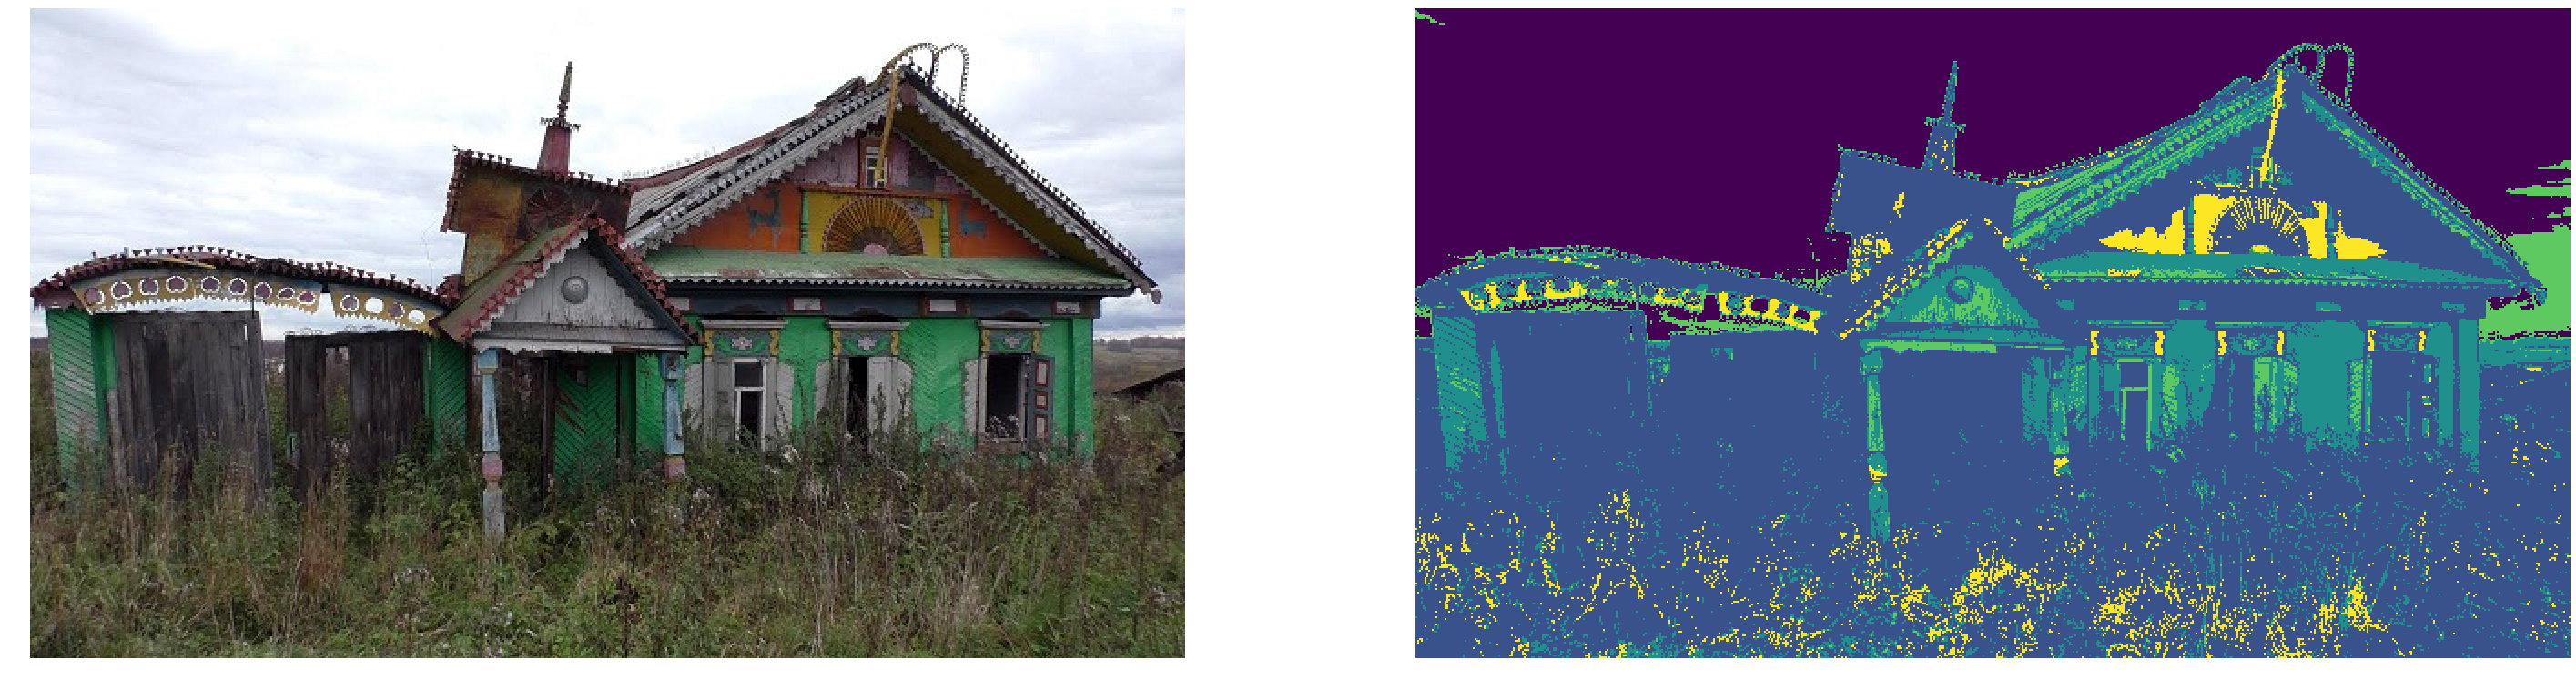

In [16]:
f = get_image_segments("images/old_house_640x360.jpg") # best (in my opinion) 2
features = np.vstack([features, f])

number of clusters : 42
max area : 55306
median area : 57
area of 20 percent's smallest segments : 15


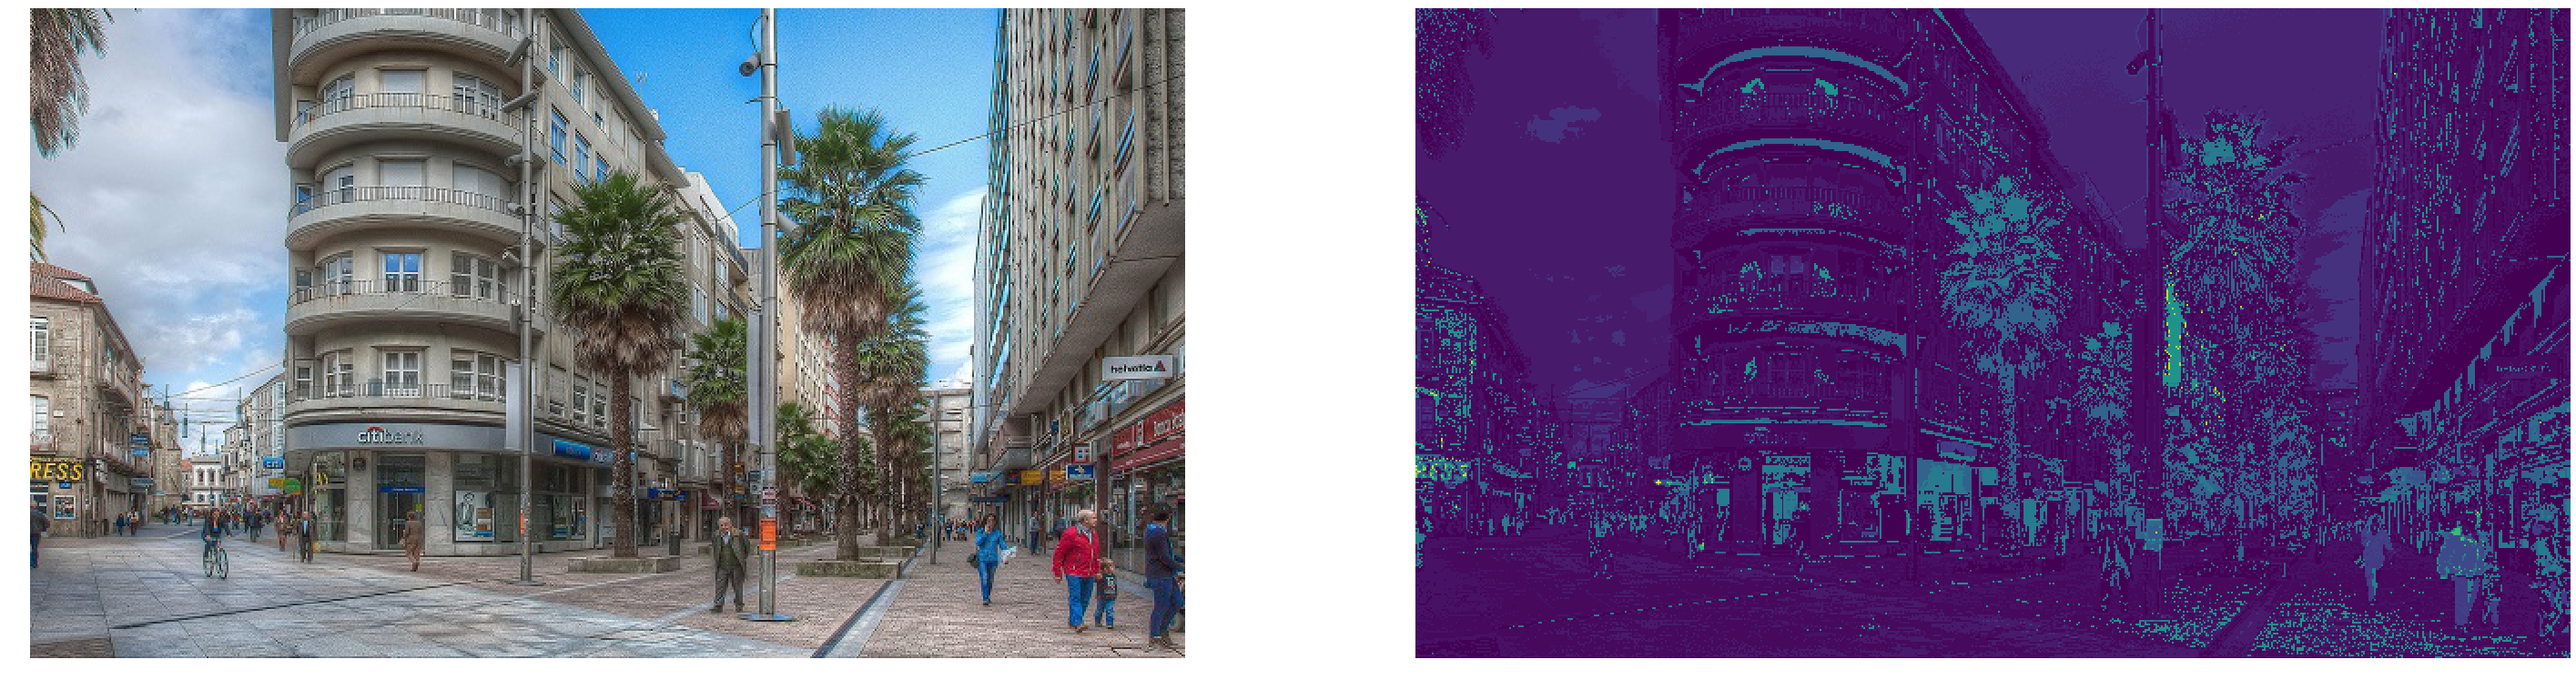

In [18]:
f = get_image_segments("images/citybank_640x360.jpg") # best (in my opinion) 3
features = np.vstack([features, f])

number of clusters : 8
max area : 105592
median area : 20401
area of 20 percent's smallest segments : 0


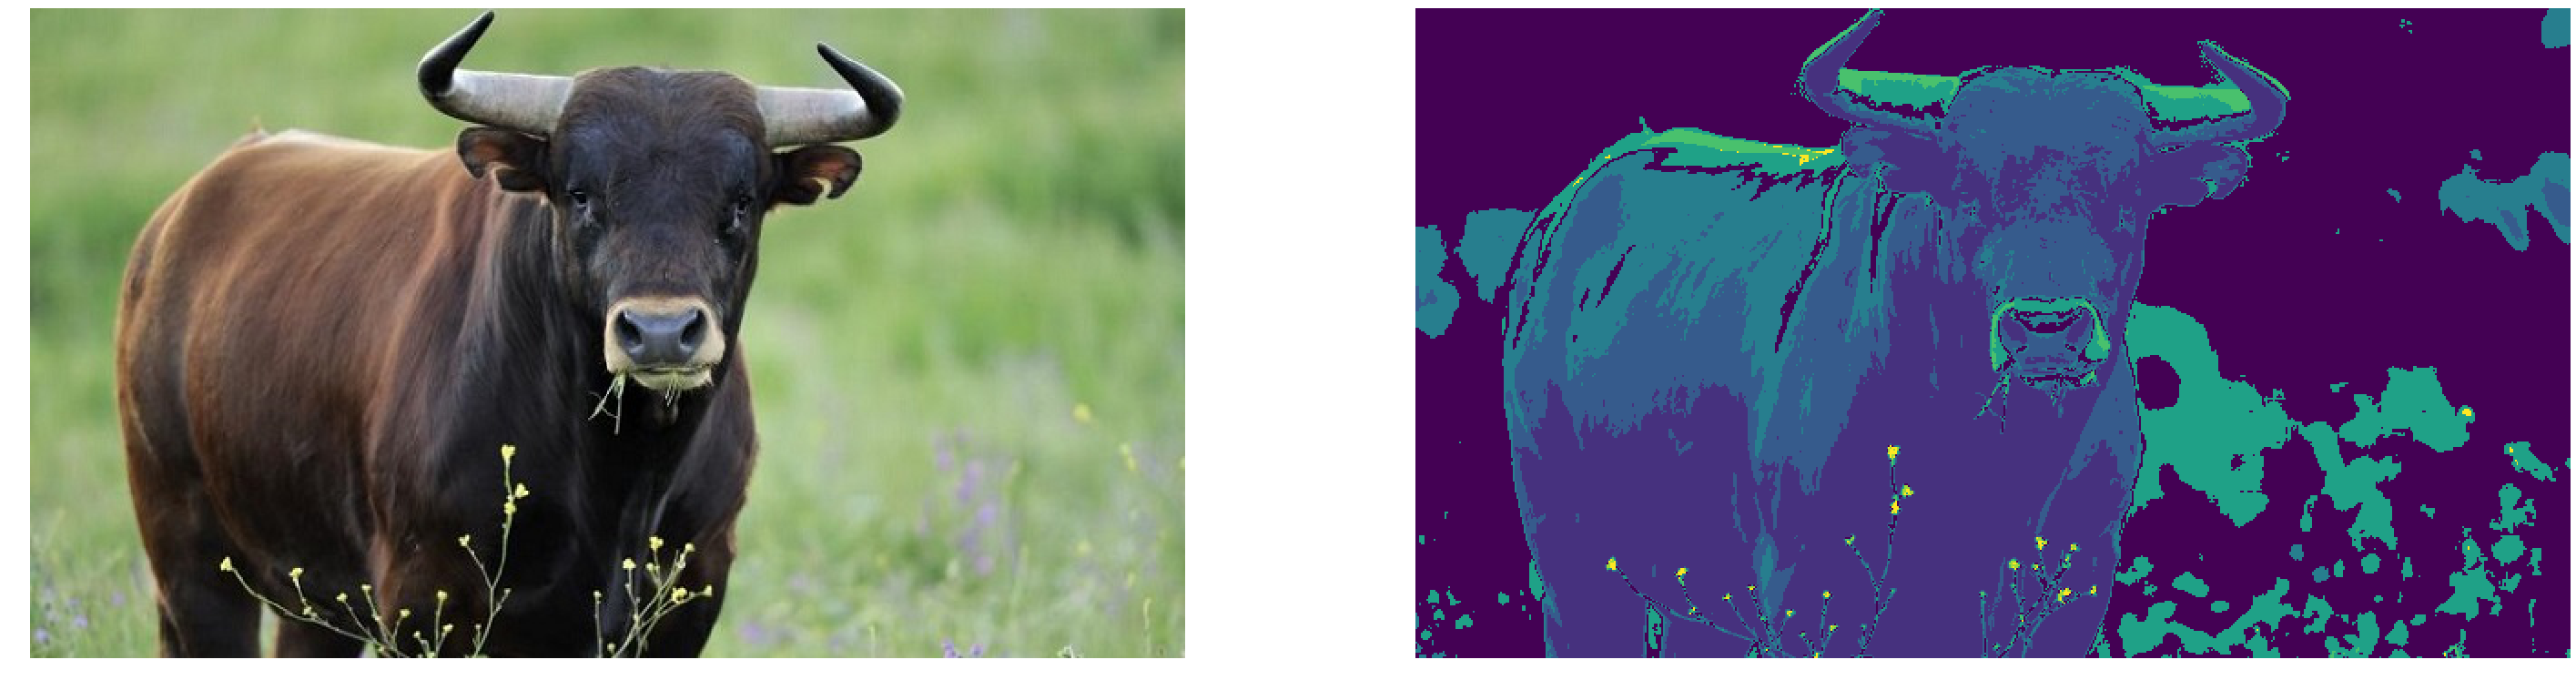

In [24]:
f = get_image_segments("images/bull_640x360.jpg") # best (in my opinion) 1
features = np.vstack([features, f])

number of clusters : 36
max area : 45377
median area : 229
area of 20 percent's smallest segments : 27


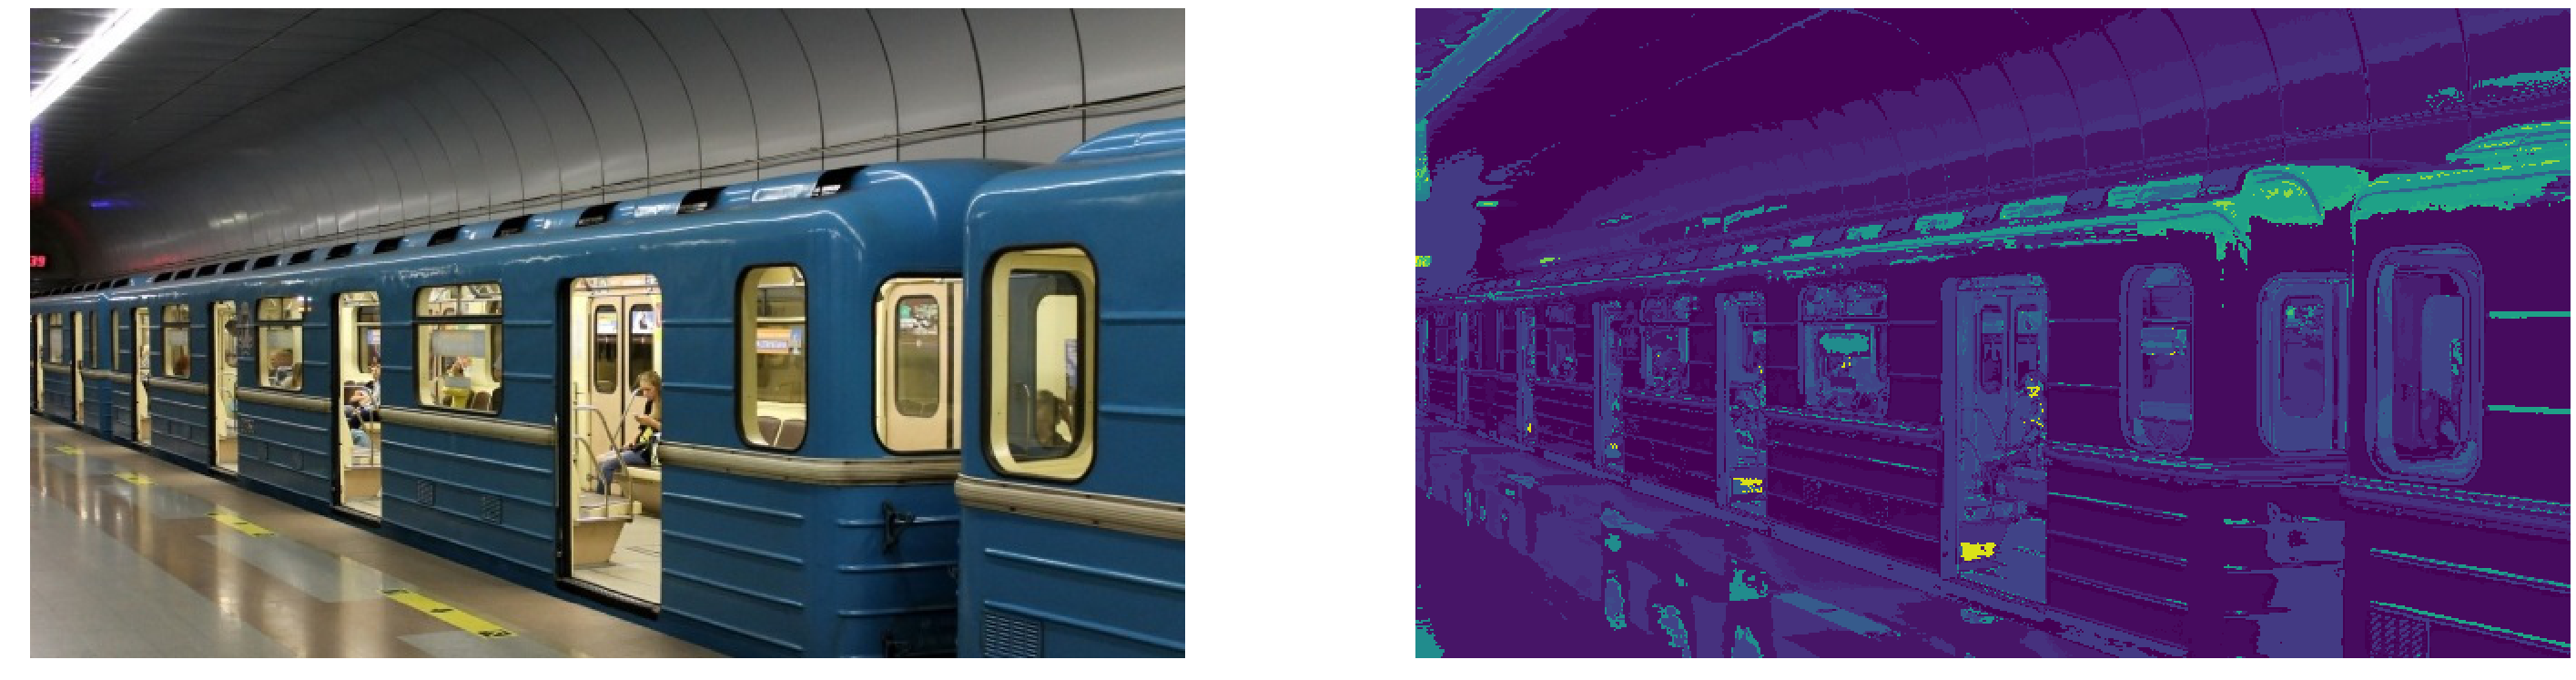

In [3]:
f = get_image_segments("images/metro_640x360.jpg") # best (in my opinion) 3
features = np.vstack([features, f])

In [6]:
print (features)

[[     9  72583  23237     94]
 [    37  51566    131     14]
 [    41  37252   1028    326]
 [    23  90774     17      6]
 [    15  68213   9362     64]
 [     5 122954  16956      0]
 [    42  55306     57     15]
 [     8 105592  20401      0]
 [    36  45377    229     27]]


**1-ый столбец:** number of clusters  
**2-ой столбец:** max area  
**3-ий столбец:** median area  
**4-ый столбец:** area of 20 percent's smallest segments


Теперь попробуем показать эти данные алгоритму регрессии

In [25]:
test = 2
X = np.concatenate((features[:test], features[1+test:]))
lables = np.array([1,4,3,1,2,2,3,1,3]) # правильные метки
y = lables[:test]
y = np.concatenate((lables[:test], lables[1+test:]))
print(X)
print(y)

[[     9  72583  23237     94]
 [    37  51566    131     14]
 [    23  90774     17      6]
 [    15  68213   9362     64]
 [     5 122954  16956      0]
 [    42  55306     57     15]
 [     8 105592  20401      0]
 [    36  45377    229     27]]
[1 4 1 2 2 3 1 3]


In [28]:
clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
clf.fit(X, y)
print(clf.predict([features[test]]))

[2.04]


Модель реомендует на изображение `"t_640x360.jpg"` наложить стиль 2

![title](images/test.jpg)

Обучающая выборка очень мала, поэтому к данному примеру стоит относиться как к демонстрационному

### варианты улучшения вышепредставленного алгоритма
Сложность алгоритма `mean shift` O(KN^2), K - число итераций, N - количество векторов.  
Можно предложить другой алгоритм выделения фичей:  
например, использовать оператор Лапласа
$$\begin{vmatrix}
-1&-1&-1\cr
-1&   8&-1\cr
-1&-1&-1
\end{vmatrix}$$
Один раз пременив к изображению фильтр, мы получим инфрмацию о границах. В качестве признаков можно использовать частоту встречаемости границ, резкось переходов и т.д.